In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as sps
import scipy as sp
from scipy import special
import lmfit as lm
import pymc3 as pm
import theano.tensor as tt
from theano import shared

In [2]:
def two_rates(t,k1,k2):
    if k1==k2:
        return k1**2*np.exp(-k1*t)
    else:
        return k1*k2/(k1-k2)*(np.exp(-k2*t)-np.exp(-k1*t))
    
def three_rates(t,k1,k2,k3):
    return k1*k2*k3/(k1-k2)*((np.exp(-k1*t)-np.exp(-k3*t))/(k1-k3)-(np.exp(-k2*t)-np.exp(-k3*t))/(k2-k3))

def four_rates(t,k1,k2,k3,k4):
    result=np.exp(-k2*t)/(k2-k3)/(k2-k4)
    result+=np.exp(-k3*t)*(k2-k1)/(k3-k1)/(k3-k2)/(k3-k4)
    result+=np.exp(-k1*t)/(k1-k3)/(k4-k1)
    result+=np.exp(-k4*t)*(k2-k1)/(k4-k1)/(k4-k2)/(k4-k3)
    return result*k1*k2*k3*k4/(k1-k2)

In [3]:
t_transfection = {
    "20171026_K1_gfp": 1.33,
    "20171026_K2_gfp": 1.33,
    "20171026_K3_gfp": 1.33,
    "20171026_K4_gfp": 1.33,
    "20171026_K5_gfp": 1.33,
    "20171026_K6_gfp": 1.33,
    "20170316_K1_gfp": 1,
    "20170316_K3_gfp": 1,
    "20170316_K5_gfp": 1,
    "20161006_DDC_gfp": -.3,
    "20161006_Lipo_gfp": -.3,
    "20161006_Lipo2_gfp": -.3,
}
analysis_k1 = pd.read_excel("astrazenecadaten/2018-03-02–120925_GFP_20170615_K1_DLin.xlsx",sheet_name="GFP_params")
analysis_k2 = pd.read_excel("astrazenecadaten/2018-03-02–120927_GFP_20170615_K2_DLin.xlsx",sheet_name="GFP_params")
analysis_k3 = pd.read_excel("astrazenecadaten/2018-03-02–120927_GFP_20170615_K3_KC2.xlsx",sheet_name="GFP_params")
analysis_k4 = pd.read_excel("astrazenecadaten/2018-03-02–120928_GFP_20170615_K4_KC2.xlsx",sheet_name="GFP_params")
analysis_k5 = pd.read_excel("astrazenecadaten/2018-03-02–120929_GFP_20170615_K5_MC3.xlsx",sheet_name="GFP_params")
analysis_k6 = pd.read_excel("astrazenecadaten/2018-03-02–120930_GFP_20170615_K6_MC3.xlsx",sheet_name="GFP_params")


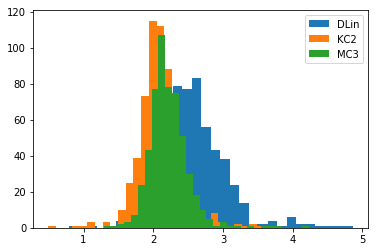

In [4]:
k1 = np.array(analysis_k1['t0'])
k2 = np.array(analysis_k2['t0'])
k3 = np.array(analysis_k3['t0'])
k4 = np.array(analysis_k4['t0'])
k5 = np.array(analysis_k5['t0'])
k6 = np.array(analysis_k6['t0'])
#plt.figure()
#plt.hist(k1)
#plt.hist(k2)
#plt.figure()
#plt.hist(k3)
#plt.hist(k4)
#plt.figure()
#plt.hist(k5)
#plt.hist(k6)
dlin = np.concatenate((k1,k2))
dlin = dlin[dlin>0]
kc2 = np.concatenate((k3,k4))
mc3 = np.concatenate((k5,k6))
plt.figure()
plt.hist(dlin, bins=30,label = "DLin")
plt.hist(kc2,bins=30,label = "KC2")
plt.hist(mc3,bins=30,label = "MC3")
plt.legend()

initial guess: 29.969343697699966
next guess: 29.970236964989454
next guess: 29.970236991761467
next guess: 29.970236991761073
next guess: 29.970236991761467
29.970236991761467 0.08458204788635934
initial guess: 40.51422031468236
next guess: 40.51488749643379
next guess: 40.51488750746685
next guess: 40.5148875074654
next guess: 40.5148875074654
40.5148875074654 0.05162225695539648
initial guess: 64.52418519865233
next guess: 64.52460840244116
next guess: 64.52460840522238
next guess: 64.52460840522974
next guess: 64.52460840522974
64.52460840522974 0.03435173127829853


/Users/hstrey/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


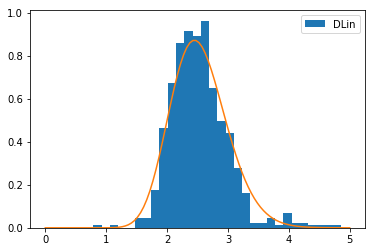

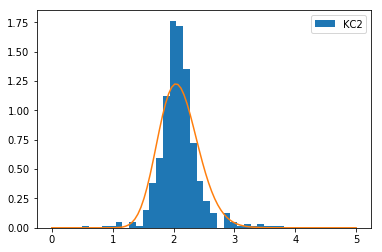

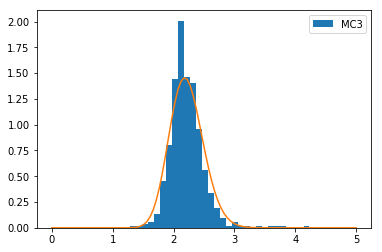

In [5]:
tp = np.linspace(0,5,100)
# lets estimate the parameters for the gamma function from the data
# first by maximum likelihood
def MLE_gamma(data,k0 = None):
    avg = data.mean()
    s = np.log(avg) - np.log(data).mean()
    if k0 is None:
        k0 = (3 - s + np.sqrt((s -3)**2 +24*s))/12/s
    print("initial guess:",k0)
    for i in range(4):
        k = k0 - (np.log(k0)-special.digamma(k0)-s)/(1/k0-special.polygamma(1,k0))
        print("next guess:",k)
        k0=k
    return (k,avg/k)

kDlin,theta_Dlin = MLE_gamma(dlin)
print(kDlin,theta_Dlin)
dlin_gamma = sps.gamma.pdf(x=tp,a=kDlin,scale=theta_Dlin)

kKC2,theta_KC2 = MLE_gamma(kc2)
print(kKC2,theta_KC2)
kc2_gamma = sps.gamma.pdf(x=tp,a=kKC2,scale=theta_KC2)

kMC3,theta_MC3 = MLE_gamma(mc3)
print(kMC3,theta_MC3)
mc3_gamma = sps.gamma.pdf(x=tp,a=kMC3,scale=theta_MC3)

plt.figure()
plt.hist(dlin, bins=30,label = "DLin",normed=True)
plt.plot(tp,dlin_gamma)
plt.legend()
plt.figure()
plt.hist(kc2,bins=30,label = "KC2",normed=True)
plt.plot(tp,kc2_gamma)
plt.legend()
plt.figure()
plt.hist(mc3,bins=30,label = "MC3",normed=True)
plt.plot(tp,mc3_gamma)
plt.legend()

In [6]:
dlin

array([2.55528573, 2.4135997 , 1.88458677, 2.48335673, 2.4256372 ,
       1.96822739, 2.33378957, 2.94543312, 2.38290541, 2.34299545,
       2.03098833, 2.36349704, 2.67934258, 2.38472247, 3.03932872,
       2.22256278, 2.58311566, 2.78778635, 2.74294119, 2.62252661,
       2.21623454, 2.48591627, 2.58679143, 2.85693592, 2.43792433,
       2.26992242, 3.26177569, 2.52998823, 2.29486947, 2.46936013,
       2.02598124, 2.29695112, 2.5923831 , 2.36452922, 2.08318239,
       3.06092315, 2.61893098, 2.24019613, 2.55062298, 2.85009056,
       2.1046934 , 2.87369905, 2.30694466, 2.66474894, 2.11523663,
       2.42602398, 2.81866394, 3.08163638, 3.04548321, 2.442325  ,
       2.34915578, 3.0874292 , 2.27475649, 3.10311974, 2.04130282,
       2.09211054, 2.47512501, 2.64425343, 2.67804084, 2.10587909,
       2.7867596 , 2.26935966, 2.39641462, 2.26660703, 2.18496673,
       1.69870109, 2.29765764, 2.68238737, 2.50055537, 1.73836581,
       1.9862506 , 1.94113979, 2.42679855, 2.20011555, 1.92463

In [7]:
data = np.array(analysis_excel['t0'])
tau_mean = data.mean()
n = data.size

beta_0_list=[]
beta_0_std_list=[]

for alpha in range(1,20):
    beta_est = alpha/tau_mean
    beta_std = beta_est/np.sqrt(n*alpha)
    beta_0_list.append(beta_est)
    beta_0_std_list.append(beta_std)
beta_0_list = np.array(beta_0_list)
beta_0_std_list = np.array(beta_0_std_list)


NameError: name 'analysis_excel' is not defined

In [ ]:
# now we need to calculate the likelihood function
def gamma_like(data,alpha,beta):
    p = sps.gamma.pdf(data,alpha,scale=1/beta)
    return np.prod(p)
def gamma_like_log(data,alpha,beta):
    p = np.log(sps.gamma.pdf(data,alpha,scale=1/beta))
    return np.sum(p)

In [ ]:
p_like_list=[]
for n,beta_0 in enumerate(beta_0_list):
    p_like_list.append(gamma_like(data,n+1,beta_0))
p_like_list=np.array(p_like_list)

In [ ]:
print(p_like_list*beta_0_std_list)

In [ ]:
plt.plot(np.arange(19)+1,p_like_list*beta_0_std_list,"o-")

In [ ]:
#plot the histogram and all the fits
x = np.linspace(0,10,100)
plt.hist(data, bins=20,normed=True)
for n,beta in enumerate(beta_0_list):
    plt.plot(x,sps.gamma.pdf(x,n+1,scale=1/beta),label=str(n+1))
    plt.legend()